In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from glob import glob
from os import listdir
from os.path import isfile, isdir, join
import datetime
import time
from termcolor import colored

import re
import sys
sys.path.insert(0, '../supermodel_test/')
from supermodel import *
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

%matplotlib inline

### choose supermodel formulation

In [2]:
### IMPORTANT: when specifying more than one fit function for steady-state or tau
### ss_transitions and tau_transitions: specifies how parameters of previous fit function relate to current one
### ss_identity and tau_identity: specifies how parameters of each fit function relate to the final one

iontype = "IH"
SM_NUM = 2

if SM_NUM==1:
    ss_fit_fcn_list = [sigmoid]  # NOTE: supermodel fcns should be in the form of a list
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2,tau_fun3]
    n_tau_params = [4,6,8]
    tau_transitions = [[0,1,2,4],[0,1,2,3,5,6]]
    tau_identity = [[0,1,2,5],[0,1,2,3,5,6],np.arange(n_tau_params[-1])]

elif SM_NUM==2:
    ss_fit_fcn_list = [sigmoid,modified_sigmoid]
    n_ss_params = [2,4]
    ss_transitions = [[0,1]]
    ss_identity = [[0,1],np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2,tau_fun3]
    n_tau_params = [4,6,8]
    tau_transitions = [[0,1,2,4],[0,1,2,3,5,6]]
    tau_identity = [[0,1,2,6],[0,1,2,3,5,6],np.arange(n_tau_params[-1])]

elif SM_NUM==3:
    ss_fit_fcn_list = [sigmoid]
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2]
    n_tau_params = [4,6]
    tau_transitions = [[0,1,2,4]]
    tau_identity = [[0,1,2,4],np.arange(n_tau_params[-1])]

elif SM_NUM==4:
    ss_fit_fcn_list = [sigmoid]
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1]
    n_tau_params = [4]
    tau_identity = [np.arange(n_tau_params[-1])]

elif SM_NUM==5:
    ss_fit_fcn_list = [sigmoid]
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2,tau_fun3,tau_fun4]
    n_tau_params = [4,6,8,10]
    tau_transitions = [[0,1,2,4],[0,1,2,3,5,6],[0,1,2,3,4,6,7,8]]
    tau_identity = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8],np.arange(n_tau_params[-1])]

In [3]:
# specify directory and load data file

path = "/media/icg-channels/icg-channels-"+iontype+"/"
mod_files = [f for f in listdir(path) if isdir(join(path, f)) and 'git' not in f]
n_mod_files = len(mod_files)

# load the dict file
f = open("/media/icg-channels/icg-channels-"+iontype+".pkl","rb")
data_dict = pickle.load(f)

# immediately save a backup just in case
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
f = open("/media/icg-channels/backup/icg-channels-"+iontype+"-"+st+".pkl",'wb')
pickle.dump(data_dict,f)

print("Running for",iontype,"models.")
print("Number of mod files: ",n_mod_files)

Running for IH models.
Number of mod files:  243


In [4]:
# specify error functions

def err1(data,fun,v,params):
    rmse = np.sqrt(np.mean((np.asarray(data)-np.asarray(fun(v, *params)))**2))
    stdev = np.std(np.asarray(data))
    return rmse / stdev
    
def err2(data,fun,v,params):
    P = CubicSpline(v,np.asarray(data))
    def area_diff_fun(x):
        return (P(x)-fun(x, *params))**2
    def area_fun(x):
        return P(x)**2
    x = quad(area_diff_fun,v[0],v[-1])
    x_norm = quad(area_fun,v[0],v[-1])
    return x[0] / x_norm[0]
    
def err3(data,fun,v,params):
    return np.linalg.norm(np.asarray(data)-np.asarray(fun(v, *params)))/np.linalg.norm(np.asarray(data))

### main loop (runs 250-300 mod files per minute)

In [5]:
# loop through all models and fit curves

maxfev = 20000  # maximum number of iterations for scipy nonlinear fit fcn
sm_str = "SM"+str(SM_NUM)

for i in range(n_mod_files):
     
    mod_name = mod_files[i]    
    rate_path = path+mod_name+"/RATES/"
    
    # rate_files = [f for f in listdir(rate_path) if isfile(join(rate_path, f))]
    try:
        if len(data_dict[mod_name]['ERROR_FLAGS']) == 0:

            rate_files = []
            valid_states = list(data_dict[mod_name]['GATES'].keys())
            for kk in valid_states:
                fs = glob(rate_path + '*.' + kk + '.*.dat')
                for fff in fs:
                    rate_files.append(os.path.basename(fff))

    #        try:
    #            exist_rates = list(data_dict[mod_name]['RATES'].keys())  # All extracted rates
    #            for ii in valid_states:   # Only entries with gates as valid
    #                exist_rates.remove(ii)   # Remaining entries to be pruned
    #            for to_prune in exist_rates:  # Pruning the remaining rate entries
    #                data_dict[mod_name]['RATES'].pop(to_prune)
    #        except KeyError:
    #            pass

            if not data_dict[mod_name]['RATES']:
                print(colored('%d %s: rates not found.' %(i, mod_name), 'red'))
                continue

            data_dict[mod_name][sm_str+'_FIT'] = True
            data_dict[mod_name][sm_str+'_PARAMS_SS'] = {}
            data_dict[mod_name][sm_str+'_PARAMS_TAU'] = {}
            data_dict[mod_name][sm_str+'_ERROR1_SS'] = {}
            data_dict[mod_name][sm_str+'_ERROR1_TAU'] = {}
            data_dict[mod_name][sm_str+'_ERROR2_SS'] = {}
            data_dict[mod_name][sm_str+'_ERROR2_TAU'] = {}
            data_dict[mod_name][sm_str+'_ERROR3_SS'] = {}
            data_dict[mod_name][sm_str+'_ERROR3_TAU'] = {}
            data_dict[mod_name]['RATE_VALS_SS'] = {}
            data_dict[mod_name]['RATE_VALS_TAU'] = {}
            data_dict[mod_name]['RATE_VALS_V'] = {}

            # loop through all rate files in this mod directory
            for j in range(len(rate_files)):

                rfile = rate_files[j]
                fsplit = rfile.split(".")
                varname = fsplit[1]
                if varname not in data_dict[mod_name]['STATES']:   # WHY!!!?
                    data_dict[mod_name]['STATES'].append(varname)
                curve_type = fsplit[2]
                d = np.loadtxt(rate_path+rfile)
                V = d[:,0]
                rate_data = d[:,1]

                if (curve_type == 'inf'):

                    if (np.max(rate_data) < 0.1 or np.min(rate_data) < 0.0 or np.std(rate_data) < 1e-6):
                        print(colored('%d %s: weird INF for rate %s' %(i, mod_name, rfile), 'magenta'))
                        data_dict[mod_name][sm_str+'_FIT'] = False
                        data_dict[mod_name][sm_str+'_PARAMS_SS'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR1_SS'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR2_SS'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR3_SS'][varname] = []
                        data_dict[mod_name]['RATE_VALS_SS'][varname] = []
                        continue
                    else:
                        for k in range(len(ss_fit_fcn_list)):
                            ss_fit_fcn = ss_fit_fcn_list[k]
                            if (k==0):
                                p0 = np.random.rand(n_ss_params[k])
                                if rate_data[0] > rate_data[-1]:
                                    p0[0] *= -1.
                            else:
                                p0 = np.zeros((n_ss_params[k]))
                                p0[ss_transitions[k-1]] = popt
                            try:
                                popt, _ = curve_fit(ss_fit_fcn, V, rate_data, p0=p0, maxfev=maxfev)
                                popt_full = np.zeros((n_ss_params[-1],))
                                popt_full[ss_identity[k]] = popt
                                data_dict[mod_name][sm_str+'_PARAMS_SS'][varname] = popt_full
                                data_dict[mod_name][sm_str+'_ERROR1_SS'][varname] = err1(rate_data,ss_fit_fcn,V,popt)
                                data_dict[mod_name][sm_str+'_ERROR2_SS'][varname] = err2(rate_data,ss_fit_fcn,V,popt)
                                data_dict[mod_name][sm_str+'_ERROR3_SS'][varname] = err3(rate_data,ss_fit_fcn,V,popt)
                                data_dict[mod_name]['RATE_VALS_SS'][varname] = rate_data
                                data_dict[mod_name]['RATE_VALS_V'][varname] = V

                            except RuntimeError as err:
                                print(colored('%d %s: INF runtime error for rate %s' %(i, mod_name, rfile), 'blue'))
                                data_dict[mod_name][sm_str+'_FIT'] = False
                                data_dict[mod_name][sm_str+'_PARAMS_SS'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR1_SS'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR2_SS'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR3_SS'][varname] = []
                                data_dict[mod_name]['RATE_VALS_SS'][varname] = []
                                break

                elif (curve_type == 'tau'):

                    if (np.max(rate_data) < 0.001):
                        print(colored('%d %s: weird TAU for rate %s' %(i, mod_name, rfile), 'green'))
                        data_dict[mod_name][sm_str+'_FIT'] = False
                        data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = []
                        data_dict[mod_name]['RATE_VALS_TAU'][varname] = []
                        continue

                    else:
                        # first fit with a straight line as a control and make sure the real fit does better
                        popt_line = np.zeros((n_tau_params[-1],))
                        popt_line[1] = np.mean(rate_data)
                        data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = popt_line
                        data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = err1(rate_data,tau_fit_fcn_list[-1],V,popt_line)
                        data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = err2(rate_data,tau_fit_fcn_list[-1],V,popt_line)
                        data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = err3(rate_data,tau_fit_fcn_list[-1],V,popt_line)
                        data_dict[mod_name]['RATE_VALS_TAU'][varname] = rate_data
                        data_dict[mod_name]['RATE_VALS_V'][varname] = V

                        # actual fitting
                        for k in range(len(tau_fit_fcn_list)):
                            tau_fit_fcn = tau_fit_fcn_list[k]
                            if (k==0):  # initialize differently for first fit
                                p0 = [V[np.argmax(rate_data)],np.mean(rate_data)] + [0]*(n_tau_params[k]-2)
                            else:       # use previous fit and zeros for new params
                                p0 = np.zeros((n_tau_params[k]))
                                p0[tau_transitions[k-1]] = popt
                            try:
                                popt, _ = curve_fit(tau_fit_fcn, V, rate_data, p0=p0, maxfev=maxfev)  
                                popt_full = np.zeros((n_tau_params[-1],))
                                popt_full[tau_identity[k]] = popt
                                # check if fit is better than line (using ERROR3, arbitrarily)
                                if (err3(rate_data,tau_fit_fcn,V,popt) < data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname]):  
                                    data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = popt_full
                                    data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = err1(rate_data,tau_fit_fcn,V,popt)
                                    data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = err2(rate_data,tau_fit_fcn,V,popt)
                                    data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = err3(rate_data,tau_fit_fcn,V,popt)
                                    data_dict[mod_name]['RATE_VALS_TAU'][varname] = rate_data
                                    data_dict[mod_name]['RATE_VALS_V'][varname] = V

                            except RuntimeError as err:
                                print(colored('%d %s: TAU runtime error for rate %s' %(i, mod_name, rfile), 'cyan'))
                                data_dict[mod_name][sm_str+'_FIT'] = False
                                data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = []
                                data_dict[mod_name]['RATE_VALS_TAU'][varname] = []
                                break
            print('%d %s: all good.' %(i, mod_name))
        else:
            print('%d %s: Fix errors first' %(i, mod_name), data_dict[mod_name]['ERROR_FLAGS'])
    except KeyError:
        print('%d %s: Error flags undefined' %(i, mod_name))

../supermodel_test/supermodel.py:12: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y)) + np.exp(d*y))
/home/chaitanya/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


0 101629_h.mod: all good.
1 144526_h.mod: all good.
2 8284_hyperde1.mod: Fix errors first [7]
3 180373_Ih.mod: all good.
4 183949_ghchan.mod: all good.
5 149737_ih_stochastic.mod: Fix errors first [4]


/home/chaitanya/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/chaitanya/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


6 148644_h.mod: all good.
7 184352_Ih.mod: all good.
8 124063_Cone_ih.mod: all good.
9 154732_h.mod: all good.
10 139421_ihpyrkop.mod: Fix errors first [1]
11 139656_Golgi_hcn2.mod: Fix errors first [4]
12 184350_Ih.mod: all good.
13 135902_CA1ih.mod: Fix errors first [5]
14 64229_hyperde3_icgIH2.mod: Fix errors first [7]


../supermodel_test/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))


15 144450_h.mod: all good.
16 55035_h.mod: all good.
17 116862_ntIh.mod: all good.
18 126814_h.mod: all good.
19 181967_h.mod: all good.
20 184327_Ih.mod: all good.


../supermodel_test/supermodel.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a*x+b))


21 114355_G_h.mod: all good.
22 144523_TNC.mod: Fix errors first [3]
23 87535_h.mod: all good.
24 64229_arhRT03.mod: Fix errors first [1]
25 20756_ar.mod: all good.
26 123453_HCN.mod: all good.
27 45539_ar.mod: all good.
28 125152_h.mod: all good.
29 124043_ih.mod: all good.
30 97874_h.mod: all good.
31 8284_hyperde3_icgIH2.mod: Fix errors first [7]
32 144579_ar.mod: all good.
33 184182_Ih.mod: all good.
34 182134_iholmw.mod: Fix errors first [1]
35 8284_hyperde2.mod: Fix errors first [7]
36 124043_h2.mod: all good.
37 87454_ih.mod: all good.
38 156120_h_chann.mod: all good.
39 137259_h.mod: all good.
40 51781_hyperde3.mod: Fix errors first [7]
41 8284_hyperso_icgIH2.mod: Fix errors first [7]
42 97917_hyperde3.mod: Fix errors first [7]
43 156780_Ih.mod: all good.
44 184310_Ih.mod: all good.
45 3332_hcno.mod: Fix errors first [4]
46 170030_h.mod: all good.
47 127305_h.mod: all good.
48 181967_Ih.mod: all good.
49 135902_ihpyrkop.mod: Fix errors first [1]
50 135898_h.mod: all good.
51 10

../supermodel_test/supermodel.py:16: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2)) + np.exp(e*y+f*y**2))


60 184319_Ih.mod: all good.
61 3684_htc.mod: all good.
62 112685_Golgi_hcn1.mod: Fix errors first [4]
63 144589_h.mod: all good.
64 7659_h.mod: all good.
65 155057_h.mod: all good.
66 149174_hyperde3.mod: Fix errors first [7]
67 74298_Ih.mod: all good.
68 118986_h.mod: all good.
69 150024_TNC.mod: Fix errors first [3]
70 64228_h.mod: all good.
71 53876_h.mod: all good.
72 121259_h2.mod: all good.
73 139657_sjg_ih.mod: all good.
74 19696_h.mod: all good.
75 139653_Ih.mod: all good.
76 185858_ihlts.mod: Fix errors first [1]
77 20007_KhdM01.mod: all good.
78 147539_h.mod: all good.
79 184325_Ih.mod: all good.
80 184145_Ih.mod: all good.
81 141063_ih.mod: all good.
82 119266_h.mod: all good.
83 140828_ar.mod: Fix errors first [5]
84 20212_iq.mod: TAU runtime error for rate q.q.tau.37.dat
84 20212_iq.mod: all good.
85 124063_Bip_ih.mod: all good.
86 84589_hdend.mod: Fix errors first [1]
87 140249_iar.mod: TAU runtime error for rate iar.h.tau.37.dat
87 140249_iar.mod: all good.
88 37857_ih.m

In [6]:
# re-save data dict, and a backup copy
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')

f = open("/media/icg-channels/backup/icg-channels-"+iontype+"-"+st+".pkl",'wb')
pickle.dump(data_dict,f)
f = open("/media/icg-channels/icg-channels-"+iontype+".pkl",'wb')
pickle.dump(data_dict,f)

In [7]:
# print summary results

err_num = 3
err_str = 'ERROR'+str(err_num)
ss_errors = [list(data_dict[x][sm_str+'_'+err_str+'_SS'].values()) for x in data_dict.keys() 
             if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
ss_errors = [item for sublist in ss_errors for item in sublist]

tau_errors = [list(data_dict[x][sm_str+'_'+err_str+'_TAU'].values()) for x in data_dict.keys()
              if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'] and not data_dict[x]['ERROR_FLAGS'])]
tau_errors = [item for sublist in tau_errors for item in sublist]

print('SS errors: ',np.mean(ss_errors),np.var(ss_errors))
print('TAU errors: ',np.mean(tau_errors),np.var(tau_errors))
skipped_files = [x for x in data_dict.keys() if not data_dict[x]['RATES']]
print('Nr skipped mod files: ', len(skipped_files))
nofit_files = [x for x in data_dict.keys() if (data_dict[x]['RATES'] and not data_dict[x][sm_str+'_FIT'])]
print('Nr unfitted mod files: ', len(nofit_files))

[[1.211703695983639e-06], [0.0020425380165527991], [8.4380743759642038e-05, 8.4646304406049537e-05, 9.5118117091995828e-05, 9.5459382948908636e-05], [0.0027930044682936577, 0.11648444714610799, 0.010752023886761207, 0.13762891045477579], [0.00099627569840318405], [8.4380743183954822e-05, 8.3639241183480322e-05, 9.4776965780056624e-05, 9.5459382870976821e-05], [0.00099627569840708241], [0.00099627569840406442], [0.00099627569840429254], [1.1181102323549652e-06], [0.00099627569840157943], [0.00099627569840083914], [8.2404371990812335e-07], [1.2117036957810573e-06], [8.3043265552607228e-06], [1.2116992858142875e-06], [5.8289910164494527e-07], [8.2603345917301722e-06], [1.2117036962543094e-06], [1.2117036959872846e-06], [0.002674491569586524, 0.11373820344854203, 0.011357325027110236, 0.13777495231175979], [6.9466564551109232e-06], [8.4380743194694481e-05, 8.3639241183793467e-05, 9.4776965843371049e-05, 9.5459382810940128e-05], [2.2308921156097104e-06], [5.2377808286761128e-05], [1.4442399

#### unused code

In [8]:
## also get params and data (for plotting)
ss_popt = [list(data_dict[x][sm_str+'_PARAMS_SS'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
ss_popt = [item for sublist in ss_popt for item in sublist]
tau_popt = [list(data_dict[x][sm_str+'_PARAMS_TAU'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
tau_popt = [item for sublist in tau_popt for item in sublist]
ss_data = [list(data_dict[x]['RATE_VALS_SS'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
ss_data = [item for sublist in ss_data for item in sublist]
tau_data = [list(data_dict[x]['RATE_VALS_TAU'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
tau_data = [item for sublist in tau_data for item in sublist]

## plotting: steady-state curves

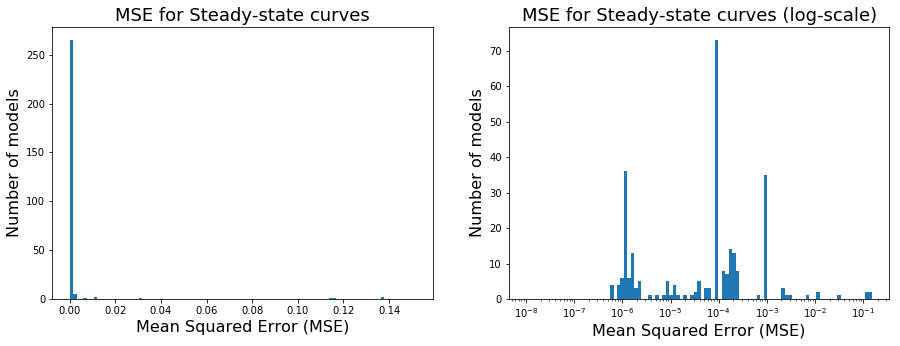

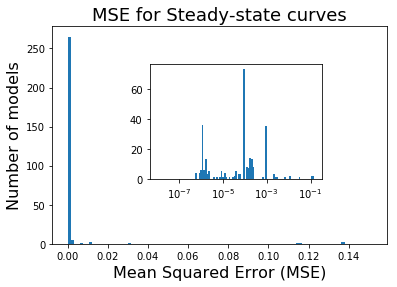

In [9]:
maxrange = 1.1*np.max(ss_errors)
maxval = 1.1*np.max(ss_errors)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
h = plt.hist(ss_errors,range=(0,maxrange),bins=100)
plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.subplot(1,2,2)
h = plt.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100))
plt.gca().set_xscale("log")
plt.title('MSE for Steady-state curves (log-scale)',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.35, 0.35, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
h = ax1.hist(ss_errors,range=(0,maxrange),bins=100)
h = ax2.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax2.set_xscale("log")
plt.sca(ax1)
plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)


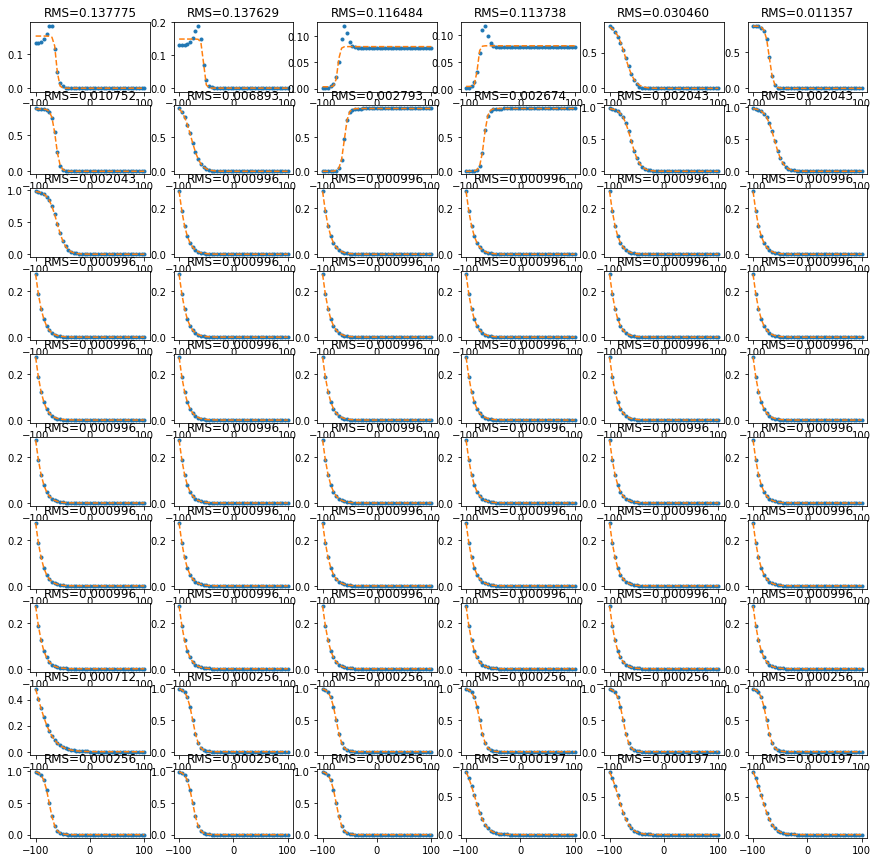

In [10]:
# plot some individual examples - arranged from worst to best

ss_inds = np.flip(np.array(ss_errors).argsort(),0)
plt.figure(figsize=(15,15))
c=1
for i in range(0,60):
    ind = ss_inds[i]
    popt = ss_popt[ind]
    data = ss_data[ind]
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, ss_fit_fcn_list[-1](V, *popt), '--')
    plt.title('RMS=%f' % ss_errors[ind])
    c += 1


## plotting: time constant curves

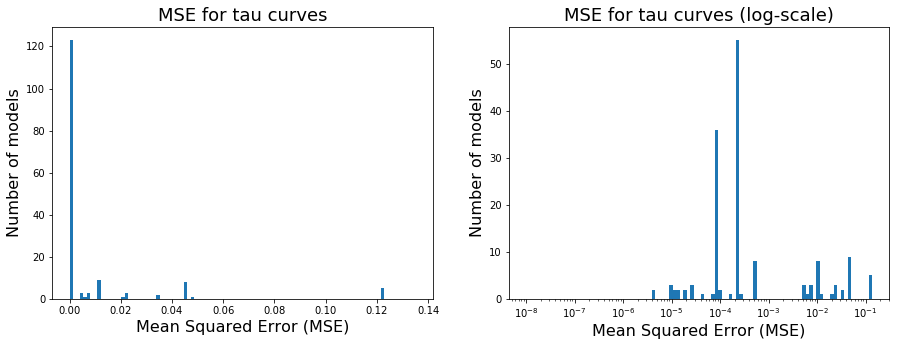

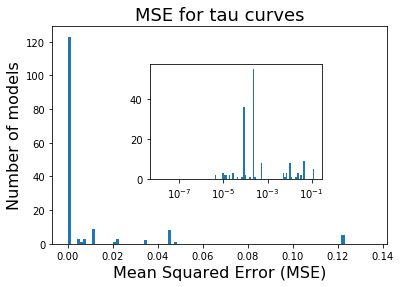

In [11]:
maxrange = 1.1*np.max(tau_errors)
maxval = 1.1*np.max(tau_errors)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
h = plt.hist(tau_errors,range=(0,maxrange),bins=100)
plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.subplot(1,2,2)
h = plt.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100))
plt.gca().set_xscale("log")
plt.title('MSE for tau curves (log-scale)',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.35, 0.35, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
h = ax1.hist(tau_errors,range=(0,maxrange),bins=100)
h = ax2.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax2.set_xscale("log")
plt.sca(ax1)
plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

ValueError: x and y must have same first dimension, but have shapes (41,) and (0,)

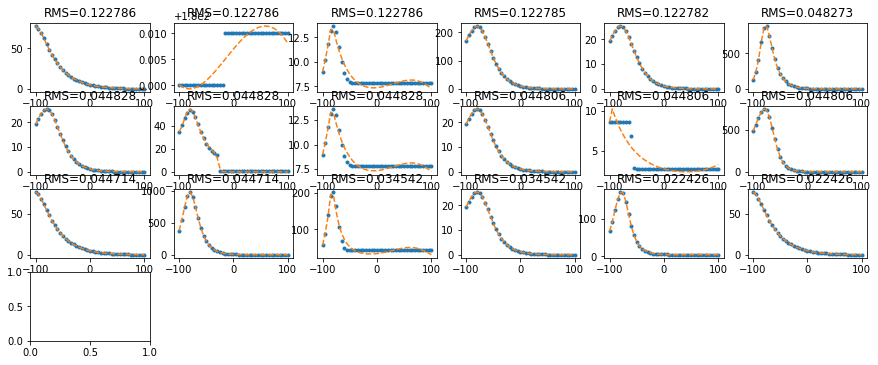

In [13]:
# plot some individual examples - arranged from worst to best

tau_inds = np.flip(np.array(tau_errors).argsort(),0)
plt.figure(figsize=(15,15))
c=1
for i in range(0,60):
    ind = tau_inds[i]
    popt = tau_popt[ind]
    data = tau_data[ind]
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, tau_fit_fcn_list[-1](V, *popt), '--')
    plt.title('RMS=%f' % tau_errors[ind])
    c += 1


# Publication figures - Fig 2

In [ ]:
# SS INF curves

maxrange = 1.1*np.max(ss_errors)
maxval = 1.1*np.max(ss_errors)

#fig, axes = plt.subplots(2,2,figsize=(15,10))
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
h = ax1.hist(ss_errors,range=(0,maxrange),bins=100)
plt.sca(ax1)
plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

# plot the good and bad fits

(r,c) = (2,0)
n = 1
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = ss_inds[-n]
        popt = ss_popt[ind]
        data = ss_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, sigmoid(V, *popt), '--')
        plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 0

(r,c) = (4,0)
n = 0
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = ss_inds[n]
        popt = ss_popt[ind]
        data = ss_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, sigmoid(V, *popt), '--')
        plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        if r==5 and c==0:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel('gating var. (1)',fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 0

# TAU

maxrange = 1.1*np.max(ss_errors)
maxval = 1.1*np.max(ss_errors)

ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
h = ax2.hist(tau_errors,range=(0,maxrange),bins=100)
plt.sca(ax2)
plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

# plot the good and bad fits

(r,c) = (2,2)
n = 1
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = tau_inds[-n]
        popt = tau_popt[ind]
        data = tau_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, tau_fit_fcn(V, *popt), '--')
        plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 2

(r,c) = (4,2)
n = 20
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = tau_inds[n]
        popt = tau_popt[ind]
        data = tau_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, tau_fit_fcn(V, *popt), '--')
        plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        if r==5 and c==2:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel(r'$\tau$ (msec)',fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 2

# Insets

left, bottom, width, height = [0.25, 0.78, 0.2, 0.15]
ax1in = fig.add_axes([left, bottom, width, height])
h = ax1in.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax1in.set_xscale("log")

left, bottom, width, height = [0.75, 0.78, 0.2, 0.15]
ax2in = fig.add_axes([left, bottom, width, height])
h = ax2in.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax2in.set_xscale("log")

plt.tight_layout()
fig.savefig("foo.pdf", bbox_inches='tight')
